In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [85]:
len(words)

32033

In [86]:
# build vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [87]:
# build dataset
block_size = 3 # context-length" numbers of chars we take to predict the new one
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
print(X)
print(Y)       
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
[[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [0, 0, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9], [22, 9, 1], [0, 0, 0], [0, 0, 1], [0, 1, 22], [1, 22, 1], [0, 0, 0], [0, 0, 9], [0, 9, 19], [9, 19, 1], [19, 1, 2], [1, 2, 5], [2, 5, 12], [5, 12, 12], [12, 12, 1], [0, 0, 0], [0, 0, 19], [0, 19, 15], [19, 15, 16], [15, 16, 8], [16, 8, 9], [8, 9, 1]]
[5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0, 1, 22, 1, 0, 9, 19, 1, 2, 5, 12, 12, 1, 0, 19, 15, 16, 8, 9, 1, 0]


In [88]:
C = torch.randn((27, 2)) # embedding 27 chars into 2D. Each char is represented by 2d vector.
C

tensor([[ 1.2909, -0.6845],
        [ 0.9148,  1.5413],
        [ 0.3201,  1.7537],
        [-0.1333, -0.5223],
        [-0.6498,  0.4513],
        [ 0.3589,  0.5721],
        [-0.2932, -1.7074],
        [ 2.4699,  1.3862],
        [-1.0048, -0.9093],
        [-0.3700,  0.7175],
        [ 0.7509, -0.2901],
        [ 0.2325,  1.4238],
        [ 0.9748, -0.6972],
        [ 1.8810, -0.2087],
        [ 0.8715,  1.6161],
        [ 0.4185, -0.0864],
        [-1.7936,  0.3995],
        [-0.5102,  0.4981],
        [-0.4569,  1.1634],
        [ 0.1865,  0.5650],
        [-0.3729,  0.0964],
        [-0.4736,  0.2974],
        [-1.1518,  0.6327],
        [-0.7077,  0.7571],
        [-0.7719, -0.0544],
        [ 2.1829,  0.9835],
        [ 2.0134,  0.7471]])

In [89]:
C[5] # 5th row/embedding similar to F.one_hot(5, num_classes=27) -> 27d vectors all zeros except 5th one is 1

tensor([0.3589, 0.5721])

In [90]:
# its like 1st layer(input layer) of nn (linear neurons) with wts matrix as C and we are encoding integers into one_hot and feeding those into nn
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # embedding of index 5 in 2d vector of 27 classes

tensor([0.3589, 0.5721])

In [91]:
# we can discard above interpretation, we can just create index and create ans use embedding tables
C[X].shape # torch.Size([32, 3, 2]) -> 32 inputs, 3 block_size each, 2 channel or 2d embedding of a char-index 

torch.Size([32, 3, 2])

In [92]:
X[13, 2], C[X][13, 2], C[1] # integer at X[13, 2] is 1 and its embedding is C[1] or C[X][13, 2]

(tensor(1), tensor([0.9148, 1.5413]), tensor([0.9148, 1.5413]))

In [93]:
# in pytorch to embed simulteneously all of the integers in x, we can simply do C[X]
embed = C[X]
embed.shape

torch.Size([32, 3, 2])

In [94]:
# construct 2nd layer of nn
W1 = torch.randn((6, 100)) # input to 2nd layer of nn is (3*2=6) as 2d embedding and we have 3 (chars) of them neurons. we can take 100 as no of neurons at 2nd layer.
b1 = torch.randn(100)

In [95]:
# for fwd pass on 2nd layer
## embed @ W1 + b1 # Error as embed(32, 3, 2) and W1(6, 100), we need to squeeze/latten the embed(_, 3, 2) to embed(_, 6). 
# we need to concatnate 3 input/neurons together. 
# 1st neuron (1st char): embed[:, 0, :], 2nd neuron (2nd char): embed[:, 1, :], 3rd neuron (3rd char): embed[:, 2, :]
torch.cat([embed[:, 0, :],embed[:, 1, :],embed[:, 2, :]], 1).shape # along 2nd dimension

# above is equivalent to the below with unbind function and works for n-neurons rather than 3
torch.cat(torch.unbind(embed, 1), 1).shape or embed.view(32, 6) # inefficient and creates new memory

torch.Size([32, 6])

In [96]:
h = torch.tanh(embed.view(32, 6) @ W1 + b1) # or h = embed.view(embed.shape[0], 6) @ W1 + b1 Or h = embed.view(-1, 6) @ W1 + b1. And b1([100]) will be broadcasted to b1([1, 100])
h.shape, h[0] # hidden layer (2nd one with 100 neurons) activation

(torch.Size([32, 100]),
 tensor([ 0.9953, -0.1836, -0.9973, -0.9951,  0.9044,  0.8482,  0.9930, -0.6706,
          0.9948, -0.9927, -0.9352, -0.9885,  0.4154, -0.5687,  0.9972, -0.5276,
          0.7299, -0.9997, -0.9999, -0.9991, -0.7692,  0.9999,  0.9923, -0.9191,
         -0.9993, -0.6912, -0.3001, -0.9912,  0.9985,  0.1264,  0.1515, -0.8492,
          0.9938, -0.3705, -0.6138,  0.9862,  0.9999,  0.9646, -0.5866, -0.7957,
         -0.8972, -1.0000,  0.9794,  0.9991, -1.0000, -0.7569, -0.9999,  0.9718,
         -0.3605, -0.7943,  0.9972, -0.9739,  0.9990,  0.9839, -0.7032, -1.0000,
          0.9650,  0.9984,  0.9990,  0.4059,  0.4596,  0.9075,  0.7413, -0.9974,
         -0.9989,  0.9997, -0.9987, -0.9969, -0.9996, -1.0000, -0.7202,  0.1427,
          0.7833,  0.9070, -0.6111, -0.9982,  0.0145,  0.4734,  0.9915,  0.2474,
          0.7570, -0.8197, -0.8311, -0.9391,  0.9967, -0.1681,  0.7565, -0.9998,
          0.9658, -0.9984,  0.9963,  0.9684, -0.9363, -0.9992,  0.9668,  0.9930,
    

In [97]:
# construct final/output layer with all 27 neurons (a-z,.)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [99]:
# output of the final layer
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [ ]:
Y # target or correct char index in 32 examples

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
torch.arange(32) # iterator for 32 index thru 0 to 31

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [103]:
# iterate/index thru each row of probs and from each row, pluck out the prob assigned to correct char
prob[torch.arange(32), Y] # iterate thru prob from 0-31 i.e each row and gets nn output prob of correct given index Y eg: prob[0, 5], prob[1, 13]..
# ideally these probs should be close to 1 when they predict correct chars

tensor([5.6097e-08, 3.8647e-14, 5.7935e-07, 7.2622e-11, 5.2231e-02, 8.4177e-05,
        2.0604e-13, 2.2067e-08, 2.0237e-08, 2.1669e-07, 2.0745e-04, 1.1143e-09,
        1.2015e-03, 3.6703e-07, 1.0961e-06, 2.3778e-02, 2.0157e-07, 6.4685e-08,
        1.1623e-02, 1.6516e-06, 9.1418e-07, 7.8987e-13, 1.1904e-13, 2.6668e-07,
        1.8832e-01, 8.0815e-08, 5.1007e-01, 5.8633e-04, 2.6383e-08, 6.7621e-12,
        7.3980e-11, 5.7643e-09])

In [105]:
loss = -prob[torch.arange(32), Y].log().mean() # -ve log-likelihood
loss

tensor(15.4255)

#--------------------Summary-------------------#

In [107]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [111]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [112]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [119]:
embed = C[X] #(32, 3, 2)
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
#prob = torch.softmax(logits, 1) # above 2 lines can be written as softmax
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [ ]:
# above classification loss can be directly calculated by cross_entropy
F.cross_entropy(logits, Y) # more efficient without creating intermediate memeory and faster/simpler backward pass. And numerically well-behaved

tensor(17.7697)

In [157]:
# build dataset
block_size = 3 # context-length" numbers of chars we take to predict the new one
X, Y = [], []

for w in words:

    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]      
X = torch.tensor(X)
Y = torch.tensor(Y)

In [161]:
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

3481

In [162]:
# create learning rates between 0.001 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # exponentially stepped


In [167]:
# put above together
lri = []
lossi = []

for i in range(1000): # epoch = 1000

    # create mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # integer that index into our dataset and that is 32 of them i.e the mini-batch size id 32

    # forward pass
    embed = C[X][ix] #(32, 3, 2) and C[X] is parallaize ix times
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # Y is parallaize ix times
    # backward pass
    for p in parameters:
        p.grad = None # set to zero-grad
    loss.backward()
    # update
    lr = lrs[i] # starts from low 0.001 and goes upto 1
    for p in parameters:
        p.data += -lr * p.grad # lr = 0.1

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

print(loss.item()) # we have only 32 examples/inputs for 1st 5 words, so easily this nn will fit (loss~0) only 32 examples and 3481 params ie. overfitting

5.485678195953369


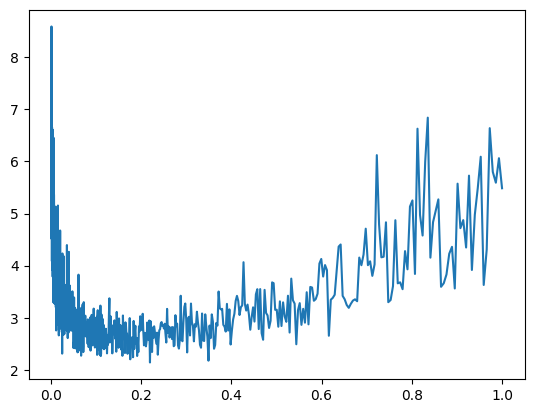

In [168]:
plt.plot(lri, lossi)

# As we are only dealing with mini batches, the quality of our gradient is lower and the direction is as realiable as the actual gradient direction but gradient direction is good enough even when its estimating on only 32 examples atht is useful.
# Its much better to have approximate gardient and just amke more steps than it is to evaluate exact gardient on whole (huge) dataset and take fewer steps. So in practice mini-batch works quite well.

# we only have 1000s of parameters and as if we have more neurons and more params like million/billions, the capacity of nn grows and it becomes more and more capable of overfitting the training set that means that loss in the training set becomes low(~0). But all that model is doing is memorizing the training set verbatim. And it won't generalize well resulting in not good model.




In [169]:
# Standard solution to above is to split the dataset into train(80%), test(10%) and val/dev(10%)
# train(80%) is used to optimize the parameters of the model (like above by using gradient descent)
# val/dev(10%) is used for development over all the hyper-parameters of the model. 
# hyperparametersa re for example are size of hidden layer, size of the embedding, strength of regularization (not used above).
# val/dev(10%) is used to validate or evaluate the model at the end.

In [171]:
#---------------Final standard approach---------------#
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [172]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [173]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [174]:
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

3481

In [175]:
# create learning rates between 0.001 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # exponentially stepped


In [180]:
lri = []
lossi = []

for i in range(1000): # epoch = 1000

    # create mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # integer that index into our dataset and that is 32 of them i.e the mini-batch size id 32

    # forward pass
    embed = C[Xtr][ix] #(32, 3, 2) and C[X] is parallaize ix times
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # Y is parallaize ix times
    # backward pass
    for p in parameters:
        p.grad = None # set to zero-grad
    loss.backward()
    # update
    #lr = lrs[i] # starts from low 0.001 and goes upto 1
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad # lr = 0.1

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

print(loss.item()) # we have only 32 examples/inputs for 1st 5 words, so easily this nn will fit (loss~0) only 32 examples and 3481 params ie. overfitting

2.4349942207336426


In [181]:
# eval with dev-set
embed = C[Xdev]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5555, grad_fn=<NllLossBackward0>)

In [182]:
# training loss just for comparison
embed = C[Xtr]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5727, grad_fn=<NllLossBackward0>)

# As above dev and training loss is almost equal hence not overfitting, means out network is small and we need to scale up the size of our neural network for performance improvement

In [183]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

10281

In [192]:
lri = []
lossi = []
stepi = []

for i in range(1000): # epoch = 1000

    # create mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # integer that index into our dataset and that is 32 of them i.e the mini-batch size id 32

    # forward pass
    embed = C[Xtr][ix] #(32, 3, 2) and C[X] is parallaize ix times
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # Y is parallaize ix times
    # backward pass
    for p in parameters:
        p.grad = None # set to zero-grad
    loss.backward()
    # update
    #lr = lrs[i] # starts from low 0.001 and goes upto 1
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad # lr = 0.1

    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item()) # we have only 32 examples/inputs for 1st 5 words, so easily this nn will fit (loss~0) only 32 examples and 3481 params ie. overfitting

2.4395980834960938


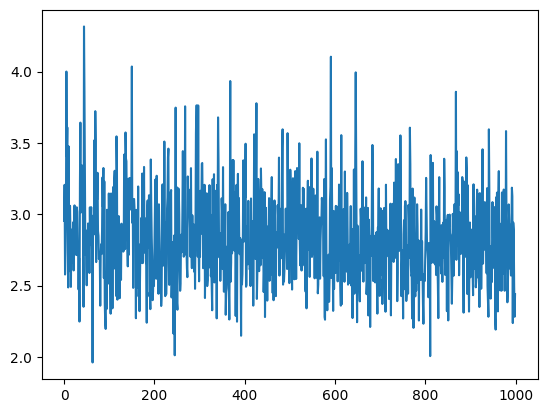

In [ ]:
plt.plot(stepi, lossi) # lots of mini-batches create thickness (up-down) in the plot
# one possibility could be the batch size is so low and this introduces noise. 
# Now we make the nn bigger with 300 neurons at 2nd layer, so we expect lower loss than previous nn (prev underfitting)
# Other imp thing: even though we made 2nd tanh layer bigger, it could be that the bottleneck of the network are now 2d embeddings. 
# As it could be that we are cramming way too much of chars into just 2 dimensionsand nn is not really able to use that space effectively.

In [194]:
# training loss just for comparison
embed = C[Xtr]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8197, grad_fn=<NllLossBackward0>)

In [195]:
# training loss just for comparison
embed = C[Xdev]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8111, grad_fn=<NllLossBackward0>)

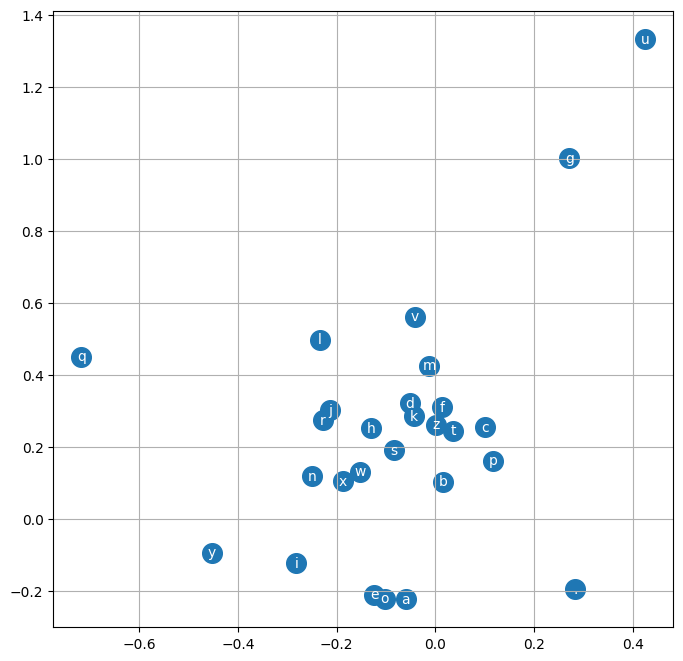

In [196]:
# training and dev losses are not improving, lets plot embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# In the above, we see that the network has learned to seperate out the chars and cluster them a lil bit, like vowels (i,e,o,e) are clusters.
# q, g and '.' are treated as an exception and have specical embedding vector.
# As we see these embeddings are not random and makes some sense, we can scale up the embedding size

In [197]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

In [198]:
lri = []
lossi = []
stepi = []

In [200]:
for i in range(1000): # epoch = 1000

    # create mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # integer that index into our dataset and that is 32 of them i.e the mini-batch size id 32

    # forward pass
    embed = C[Xtr][ix] #(32, 3, 2) and C[X] is parallaize ix times
    h = torch.tanh(embed.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # Y is parallaize ix times
    # backward pass
    for p in parameters:
        p.grad = None # set to zero-grad
    loss.backward()
    # update
    #lr = lrs[i] # starts from low 0.001 and goes upto 1
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad # lr = 0.1

    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item()) # we have only 32 examples/inputs for 1st 5 words, so easily this nn will fit (loss~0) only 32 examples and 3481 params ie. overfitting

3.078141927719116


In [ ]:
plt.plot(stepi, lossi)

# So we do following changes to beat the previous model training/dev losses:
# 1. change the no of input chars feeding into as context at as time to the model i.e. no of neurons at input layer > 3
# 2. increate the char embedding vector size i.e dimensionality of lookup table
# 3. No of neurons at hidden(2nd) layer
# 4. no of steps or how long or how many iteration we are running
# 5. what is the learning rate and how it changes(decay) over time
# 6. change the batch size to achieve a much bttter convergence speed in terms of how many min/sec it takes to train the model

In [201]:
# Finaly samples/outputs from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

chrmar.
qui.
hara.
kimera.
eet.
khyaeys.
eer.
hubi.
emera.
cheree.
ele.
mara.
cheiavin.
lece.
hasma.
kinde.
sys.
sulin.
aria.
biro.
